# Multiclass classification prediction for popularity of a song

Import all the packages

In [94]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

%matplotlib widget
import matplotlib.pyplot as plt

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

## Import data

In [95]:
df = pd.read_csv("spotify_data/spotify_songs.csv")

df = df.drop(['track_id','track_name','track_album_id','track_album_name','playlist_id','playlist_name'], axis= 1 ) # These features are not needed for prediction
df.head()

,track_artist,track_popularity,track_album_release_date,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,Ed Sheeran,66,2019-06-14,pop,dance pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,Maroon 5,67,2019-12-13,pop,dance pop,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,Zara Larsson,70,2019-07-05,pop,dance pop,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,The Chainsmokers,60,2019-07-19,pop,dance pop,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,Lewis Capaldi,69,2019-03-05,pop,dance pop,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [96]:
df.shape

(32833, 17)

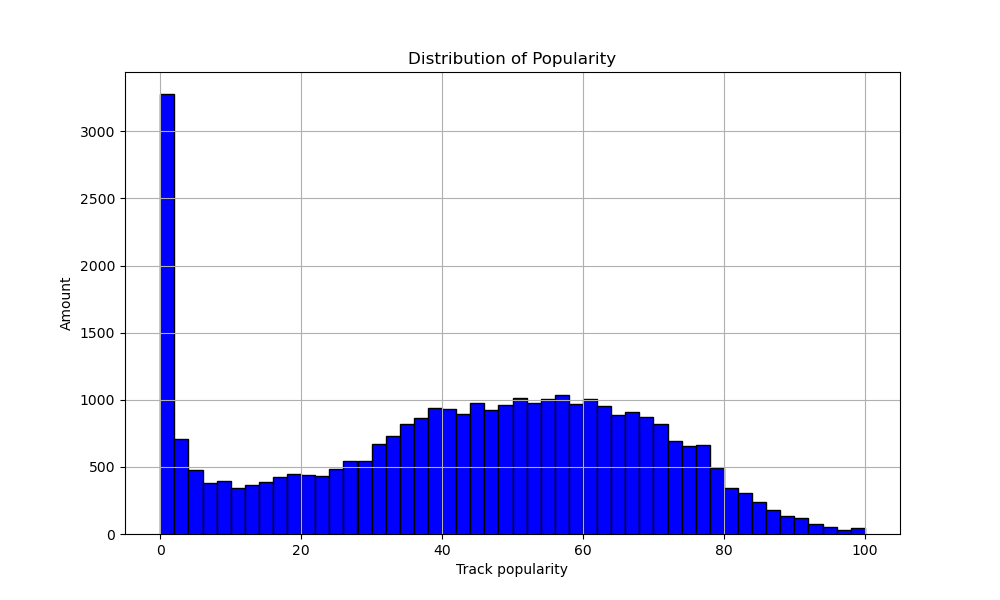

In [97]:
# Plot the distribution of track_popularity
plt.figure(figsize=(10,6))
plt.hist(df['track_popularity'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Popularity')
plt.xlabel('Track popularity')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

### Checking for null or NaN values

In [98]:
missing_popularity = df['track_popularity'].isnull().any()

missing_popularity

False

## Drop the songs with popularity zero

In [99]:
df = df[df['track_popularity'] != 0]

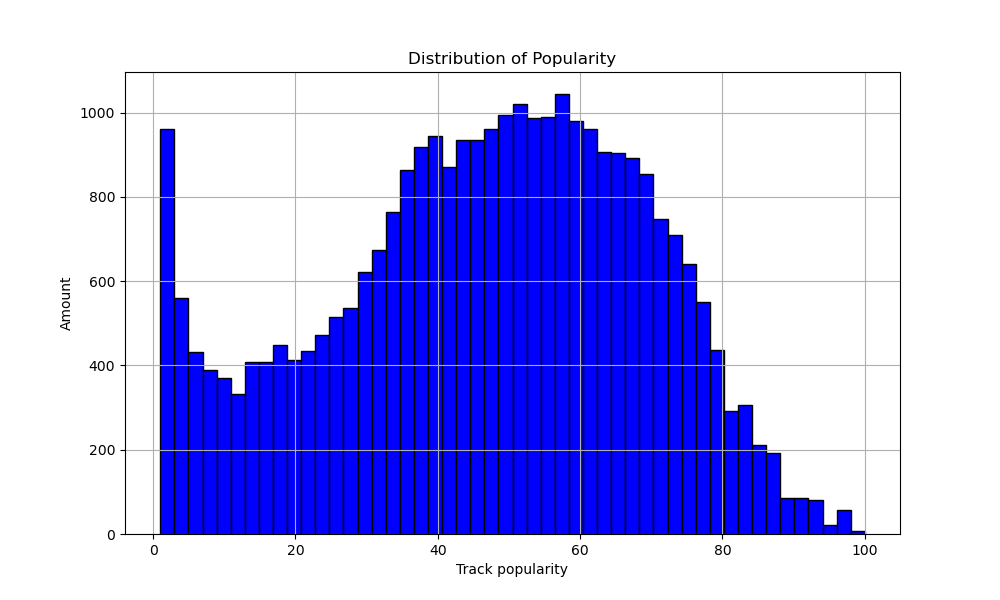

In [100]:
# Plot the distribution of track_popularity
plt.figure(figsize=(10,6))
plt.hist(df['track_popularity'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Popularity')
plt.xlabel('Track popularity')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30130 entries, 0 to 32832
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_artist              30130 non-null  object 
 1   track_popularity          30130 non-null  int64  
 2   track_album_release_date  30130 non-null  object 
 3   playlist_genre            30130 non-null  object 
 4   playlist_subgenre         30130 non-null  object 
 5   danceability              30130 non-null  float64
 6   energy                    30130 non-null  float64
 7   key                       30130 non-null  int64  
 8   loudness                  30130 non-null  float64
 9   mode                      30130 non-null  int64  
 10  speechiness               30130 non-null  float64
 11  acousticness              30130 non-null  float64
 12  instrumentalness          30130 non-null  float64
 13  liveness                  30130 non-null  float64
 14  valenc

## Divide track_popularity in classes(labels)

In [102]:
# Define the bin edges and labels
bin_edges = [0, 25, 50, 75, 100]
bin_labels = ['Shit', 'Average', 'Hit', 'Monsterhit']

# Create a new column 'popularity_label' based on the bins
df['track_popularity_label'] = pd.cut(df['track_popularity'], bins=bin_edges, labels=bin_labels, include_lowest=True)

In [103]:
df = df.drop(['track_popularity'],axis=1)

## Change release date to release year + scale duration to seconds

In [104]:
# Release date to years
df['track_album_release_date'] = pd.to_datetime(df['track_album_release_date'], errors='coerce')
df['release_year'] = df['track_album_release_date'].dt.year

df = df.drop(['track_album_release_date'], axis=1)

In [105]:
# Track duration from ms to s
df['duration_ms'] = df['duration_ms']/1000

In [106]:
df = df.rename(columns={'duration_ms': 'duration_s'})

In [107]:
df.head()

,track_artist,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,track_popularity_label,release_year
0,Ed Sheeran,pop,dance pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194.754,Hit,2019
1,Maroon 5,pop,dance pop,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162.600,Hit,2019
2,Zara Larsson,pop,dance pop,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176.616,Hit,2019
3,The Chainsmokers,pop,dance pop,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169.093,Hit,2019
4,Lewis Capaldi,pop,dance pop,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189.052,Hit,2019


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30130 entries, 0 to 32832
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   track_artist            30130 non-null  object  
 1   playlist_genre          30130 non-null  object  
 2   playlist_subgenre       30130 non-null  object  
 3   danceability            30130 non-null  float64 
 4   energy                  30130 non-null  float64 
 5   key                     30130 non-null  int64   
 6   loudness                30130 non-null  float64 
 7   mode                    30130 non-null  int64   
 8   speechiness             30130 non-null  float64 
 9   acousticness            30130 non-null  float64 
 10  instrumentalness        30130 non-null  float64 
 11  liveness                30130 non-null  float64 
 12  valence                 30130 non-null  float64 
 13  tempo                   30130 non-null  float64 
 14  duration_s            

## Making the model

### Dataset

In [109]:
X, y = df.drop('track_popularity_label',axis=1), df['track_popularity_label']

In [110]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of y is: ' + str(y.shape))

The shape of X is: (30130, 16)
The shape of y is: (30130,)


In [111]:
# UNQ_C2
# GRADED CELL: Sequential model
tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [
        ### START CODE HERE ###

        tf.keras.Input(shape=(16,)),    #specify input shape
        Dense(15, activation="relu", name="L1"),
        Dense(10, activation="relu", name="L2"),
        Dense(4, activation="linear", name="L3"),
        
        ### END CODE HERE ###
    ], name = "my_model"
)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [112]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 15)                255       
                                                                 
 L2 (Dense)                  (None, 10)                160       
                                                                 
 L3 (Dense)                  (None, 4)                 44        
                                                                 
Total params: 459 (1.79 KB)
Trainable params: 459 (1.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [113]:
[layer1, layer2, layer3] = model.layers

In [114]:
#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (16, 15), b1 shape = (15,)
W2 shape = (15, 10), b2 shape = (10,)
W3 shape = (10, 4), b3 shape = (4,)


In [115]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(
    X,y,
    epochs=40
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).